# Network data analysis

Network data is a powerful way to model and analyze interconnected systems. In Earth Sciences, researchers use network data to:

* Measure accessibility to critical services

* Identify vulnerable links in a network

* Simulate how natural hazards disrupt mobility

* Evaluate evacuation routes or supply chain delays

In this lecture we will use the Python library `OSMnx` and `NetworkX` packages to conduct network analysis to answer a more trivial question: how many cafes can we walk to in 35 minutes from Grainger Hall? By investigating this question, we will learn how to (1) download data from **OpenStreetMap (OSM)**, (2) interpret the primary components of a **graph**, and (3) perform some basic network data analysis that could be applied to other types of **relational data**.

In [1]:
import numpy as np
import geopandas as gpd

import osmnx as ox
import networkx as nx

import os
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiLineString

import matplotlib.pyplot as plt
import folium

## OpenStreetMap

OpenStreetMap (OSM) is a project that is building a free map of the whole world. Thousands of members are teamed to create an accurate, detailed and up-to-date map that is as good or better than commercial products. Like Wikipedia, OpenStreetMap benefits from the ongoing input of thousands of people around the world.

* Everyone can contribute and add objects.


* More than eight million participant accounts with more than 16,000 (and rapidly growing) of those highly active members in multiple languages.



* Anyone can access the OSM map data for free, and it already is being used in many applications.


* There already is full coverage in most urban areas and data is used in many commercial applications.

```{image} images/osm.png
:width: 800px
:align: center
```

## Network data

Most geospatial data is represented in one of two spatial models, **vector-based**, i.e. points, lines and polygons, or **raster-based**, i.e. cells of a continuous grid surface. The vector data model is **feature-oriented**, as it represents space as a series of discrete entities.

Network data represents **interconnections** between **features**. Almost everyone has needed a type of network analysis in their life. 

For example:

* What is the shortest route to the beach?


* Where should we build a hospital to best serve a community?


* How can I optimize a package delivery route?


```{image} images/shortest_route.png
:width: 600px
:align: center
```

## Types of network data

In a network, each **feature** is represented by a **node** and **connections** between nodes are represented by **edges**. There are four main types of network diagram.

```{image} images/network1.png
:width: 600px
:align: center
```


```{image} images/network2.png
:width: 600px
:align: center
```

## `NetworkX`

```{image} images/networkx.png
:width: 600px
:align: center
```

## `OSMnx `

A Python package to retrieve, model, analyze, and visualize street **networks** from **OpenStreetMap**. Users can download and model walkable, drivable, or bikeable urban networks with a single line of Python code, and then easily analyze and visualize them. 

```{image} images/osmnx.png
:width: 800px
:align: center
```

## Retrieve OSM data

First we will retrieve all features labeled (or tagged) as **buildings** in Durham from OSM using `OSMnx`. 

In [2]:
# Specify type of data
tags = {'building': True}

# Download building geometries from OSM
gdf = ox.features.features_from_place('Durham, NC, USA', tags=tags)

This produces a large `GeoDataFrame` containing over 83,000 buildings. 

In [3]:
print(gdf.shape)

(83593, 254)


For the purposes of this assignment, we are only interested in **cafes** which are usually tagged as an **`amenity`** in OSM but sometimes can be tagged a **`shop`**. We can filter them using a string comparison.

In [4]:
# Filter cafes and pastry shops
cafes = gdf[(gdf['amenity'] == 'cafe') | (gdf['shop'] == 'pastry') | (gdf['shop'] == 'bakery')].reset_index()
print(cafes.shape)

(15, 256)


We find that there are 15 cafes/bakeries in Durham. This could well be an underestimate since there could be cafes that were not tagged as amenities when mapped. But let's keep moving forward and plot them. 

The cafes are acually **polygons** so we will compute their **centroids** to make it simpler to plot. 

In [5]:
# Get cafe centroids
cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

We can visulize interactively using `folium`. Again don't be too worried if you haven't used this library, we will cover it in a future lecture.

In [6]:
# Define center of map (i.e. Grainger Hall) and initial zoom level
lat_lon = [36.0046, -78.9426]
m = folium.Map(location=lat_lon, zoom_start=12)

for i in range(0, cafes.shape[0]):
    my_string = cafes.iloc[i]['name']
    folium.Marker([cafes.iloc[i]['centroid'].y, cafes.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

## Produce a graph (or network)

We will now produce a network using roads, sidewalks, and trails features in OSM. The [`graph`](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.graph) module in `OSMnx` automatically process a network topology from raw OpenStreetMap data. 

```{note}
A **network** is also known as a **graph** in mathematics.
```

```{image} images/graph_elements.png
:width: 500px
:align: center
```

We will use the `graph_from_point` function which accepts a **point** (as lat/lon), a **distance** (in meters), and a **network type**. The options for **network type** are available in [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_point) and include `"all_private"`, `"all"`, `"bike"`, `"drive"`, `"drive_service"`, `"walk"`. We choose a distance of **2 miles** and the `walk` option since we are interested in cafes that are walkable. 

In [7]:
# Define coordinates of Grainger Hall
lat_lon = (36.0046, -78.9426)

# Define walkable street network 2 mile around Grainger Hall
g = ox.graph_from_point(lat_lon, dist=3200, network_type='walk')

Let's see what the graph looks like...

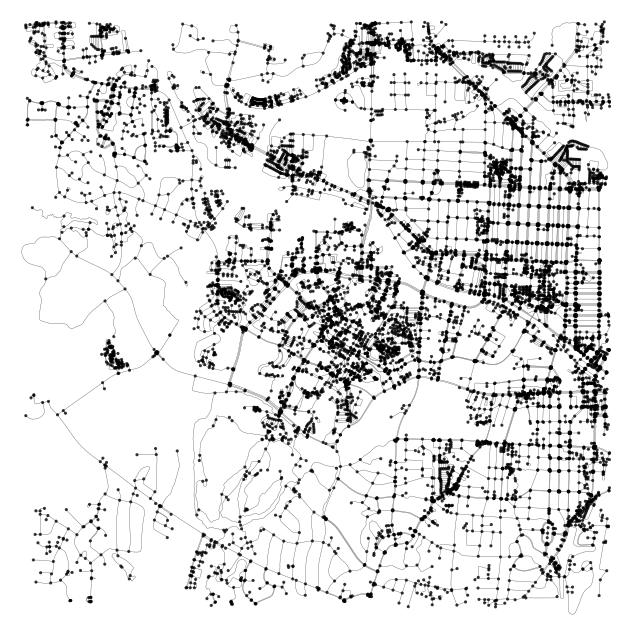

In [8]:
# Plot map
fig, ax = ox.plot_graph(g, node_alpha=0.8, edge_linewidth=0.2, edge_color="grey", bgcolor='white', node_color='black', 
                             node_size=5)

The first thing to note is that the network structure consists of **nodes** (dots) and **edges** (lines). Nodes represent objects while edges represent the relationship between those objects.

Since our network represents transport infrastructure, nodes represent intersections/dead-ends and edges represent the street segments that link them. If we were studying social relationships between Facebook users, nodes would represent users and edges would represent relationships between them (e.g. friendships or group memberships). 

Also note that the graph is [`MultiDiGraph NetworkX`](https://networkx.org/documentation/stable/reference/classes/multidigraph.html) object. `Multi` means that multiple edges are allowed between any pair of nodes. `Di` stands for **directed** which means that all our edges are directional. Bidirectional streets are therefore represented with **two edges** (with identical geometries): one from node 1 to node 2 and another from 2 to 1, to represent both possible directions of flow. 

In [9]:
type(g)

networkx.classes.multidigraph.MultiDiGraph

We can call the [`info`](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.info.html) function on the graph to see how many nodes and edges it contains.

In [10]:
print("Nodes:", g.number_of_nodes())
print("Edges:", g.number_of_edges())

Nodes: 11200
Edges: 32424


## Reproject network

Once we have produced our graph (or network, it is good practice to **reproject** it to UTM coorindates so we can work in SI units (i.e. meters) instead of degrees. The [`graph_project`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.projection.project_graph) function can be used to reproject the graph. The docs note that if the `to_crs` argument is set to `None`, the graph is projected to the UTM coordinate system for the UTM zone in which the graph's centroid lies. 

In [11]:
# Convert to graph
graph_proj = ox.project_graph(g, to_crs=None)

## Define points of interest

Next we define the centroid locations of Grainger Hall and our cafes, making sure that they are in the same projection as our graph (i.e. UTM Zone 17N or EPSG:32617). 

We can find Grainger Hall in our original OSM building data using string matching. Note that we can use [`https://www.openstreetmap.org/`](https://www.openstreetmap.org/) to find the name of specific buildings.

```{image} images/environment-hall.png
:width: 800px
:align: center
```

In [12]:
# Get coordinates of Grainger Hall
grainger_hall = gdf[gdf['name'] == 'Environment Hall'].reset_index()

# Reproject to UTM Zone 17N
grainger_hall = grainger_hall.to_crs('EPSG:32617')
cafes = cafes.to_crs('EPSG:32617')

Compute centroids...

In [13]:
grainger_hall['centroid'] = grainger_hall['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

Format the centroids as a **list**

```{note}
To begin with we will only compute the shortest distance between Grainger Hall and the **first** cafe in our `GeoDataFrame`.
```

In [14]:
# Get x and y coordinates of Grainger Hall
orig_xy = [grainger_hall['centroid'].y.values[0], grainger_hall['centroid'].x.values[0]]

# Get x and y coordinates of the first cafe
target_xy = [cafes['centroid'].y.values[0], cafes['centroid'].x.values[0]]

## Find the shortest path between points

The [`distance`](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.distance) module in `OSMnx` contains functions for calculating distances, shortest paths, and finding nearest node/edge(s) to point(s). Since the coordinates of our points are unlikely to exactly align with one of the nodes, we first have to find the nearest node to our points using the `nearest_nodes` function. 

In [15]:
# Find the node in the graph that is closest to the origin point
orig_node = ox.distance.nearest_nodes(graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

Now we can compute the shortest distance between our two points using the [`shortest_path`](https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html) functions available from `NetworkX`. The [`shortest_path`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path.html#networkx.algorithms.shortest_paths.generic.shortest_path) function returns a list of nodes along the shortest path, and the [`shortest_path_length`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.shortest_path_length.html#networkx.algorithms.shortest_paths.generic.shortest_path_length) function returns the length of this path.

```{note}
The `weight` argument defines the edge attribute to minimize when solving shortest path. In our case, we would like the **shortest distance** so we choose `length`. 
```

In [16]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
length = nx.shortest_path_length(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [17]:
print("Shortest path distance = {t:.1f} km.".format(t=length/1000))

Shortest path distance = 2.5 km.


The `route` variable contains a list of the nodes constituting the shortest path between the two points. It can plotted using the `plot_route_folium` function.

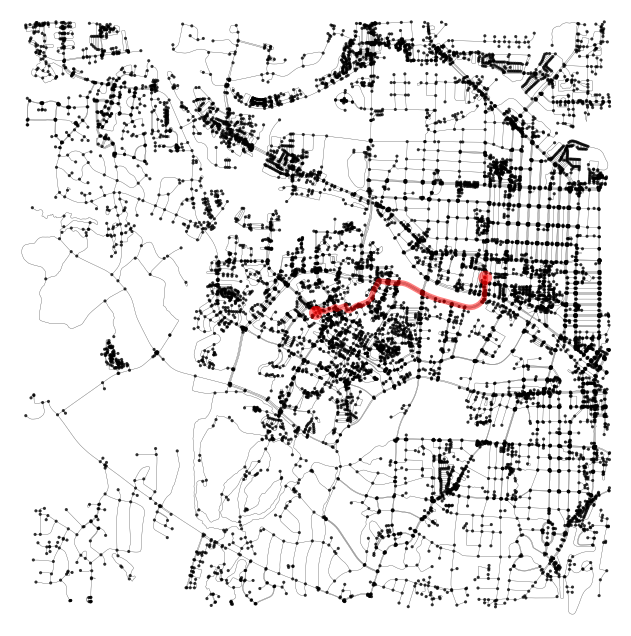

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [18]:
# Plot the shortest path using folium
m = ox.plot.plot_graph_route(g, route, route_color='r', route_linewidth=4, route_alpha=0.5, 
                             node_alpha=0.8, edge_linewidth=0.2, edge_color="grey", bgcolor='white', node_color='black', 
                             node_size=5)
m

## Find the distance to many cafes

To compute the shortest distance from Grainger Hall to **all** the cafes we can make a list of all target locations, find the nearest node for each target location, and loop over them like so...

In [19]:
target_xy = [cafes['centroid'].y.values, cafes['centroid'].x.values]

target_nodes = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

routes = []
lengths = []
for i in range(len(target_nodes)):
    routes.append(nx.shortest_path(G=graph_proj, source=orig_node, target=target_nodes[i], weight='length'))
    lengths.append(nx.shortest_path_length(G=graph_proj, source=orig_node, target=target_nodes[i], weight='length'))

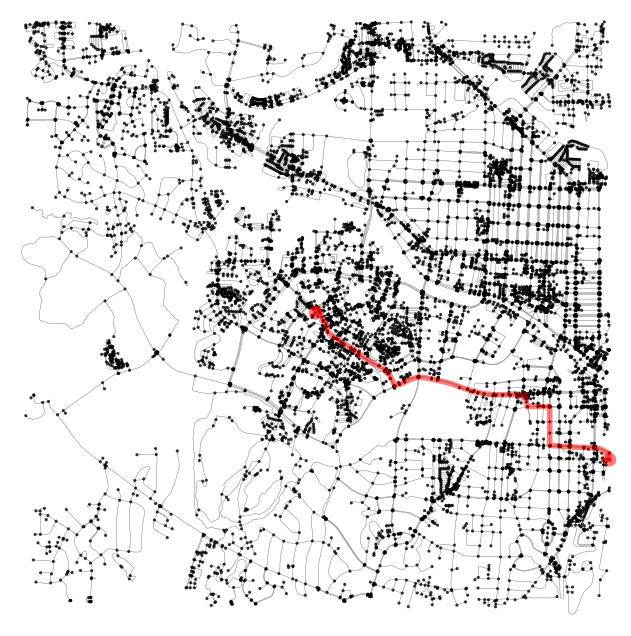

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [20]:
# Plot the shortest path using folium
m = ox.plot.plot_graph_route(g, routes[7], route_color='r', route_linewidth=4, route_alpha=0.5, 
                             node_alpha=0.8, edge_linewidth=0.2, edge_color="grey", bgcolor='white', node_color='black', 
                             node_size=5)
m

Make a list of the nearest ten cafes from Grainger Hall.

In [21]:
cafes['distance_km'] = np.array(lengths) / 1000
cafes[['name', 'distance_km']].nsmallest(columns='distance_km', n=10)

,name,distance_km
12,Twinnies Cafe,0.430875
4,Panaderia La Loma,2.283123
0,9th Street Coffee and Juice Bar,2.526072
3,Francesca's Dessert Cafe,2.526072
2,Mad Hatter's Bake Shop,2.578312
9,Baby Scratch,3.399804
10,Cocoa Cinnamon,3.461331
5,Miel Bon Bons I Fine Chocolate & Macarons l Ex...,3.549382
6,Cocoa Cinnamon,4.028373
8,Starbucks,4.277146


Finally, we can convert distance to time using an assumed walking speed of 4.5 kph (or 2.8 mph).

In [22]:
travel_speed_minutes = 4.5 / 60

In [23]:
cafes['time_minutes'] = cafes['distance_km'] / travel_speed_minutes
cafes[['name', 'distance_km', 'time_minutes']].nsmallest(columns='distance_km', n=10)

,name,distance_km,time_minutes
12,Twinnies Cafe,0.430875,5.744994
4,Panaderia La Loma,2.283123,30.441644
0,9th Street Coffee and Juice Bar,2.526072,33.680957
3,Francesca's Dessert Cafe,2.526072,33.680957
2,Mad Hatter's Bake Shop,2.578312,34.377492
9,Baby Scratch,3.399804,45.330724
10,Cocoa Cinnamon,3.461331,46.151080
5,Miel Bon Bons I Fine Chocolate & Macarons l Ex...,3.549382,47.325098
6,Cocoa Cinnamon,4.028373,53.711641
8,Starbucks,4.277146,57.028607


## Isochrones

Another way to approach this problem would be to find all the **buildings** that we would be prepared to walk to in a **given time period**, and then find all buildings labeled as cafes. This may be a more logical approach since we don't have to rely on finding all the cafes at the start of the analysis - and we know some are likely to be missing. We can also visualize our results using an [**isochrone map**](https://en.wikipedia.org/wiki/Isochrone_map), a popular type of map where each color represents an area accessible from a point within a certain time threshold. 

## Edge and node attributes

To conduct this analysis, it is useful to spend a little more time thinking about the attributes of **nodes** and **edges** of the `MultiDiGraph` object that is produced by `OSMnx`.

In [24]:
type(graph_proj)

networkx.classes.multidigraph.MultiDiGraph

We can explore the **edge** and **node** attributes easier if we convert the `MultiDiGraph` to a `GeoDataFrame`. We'll have a look at the nodes first since they are a bit more intuitive. In our infrastructure network, nodes represent intersections/dead-ends, 

In [25]:
nodes = ox.graph_to_gdfs(graph_proj, nodes=True, edges=False)
edges = ox.graph_to_gdfs(graph_proj, nodes=False, edges=True)

### Nodes

In [26]:
nodes.head()

,y,x,highway,street_count,junction,geometry
osmid,,,,,,
170501915,3.988635e+06,684398.282096,traffic_signals,3,NaN,POINT (684398.282 3988634.57)
7838622038,3.988598e+06,684405.136122,NaN,3,NaN,POINT (684405.136 3988597.578)
170505304,3.988816e+06,684367.392224,traffic_signals,3,NaN,POINT (684367.392 3988815.727)
170501953,3.988373e+06,683587.447833,NaN,3,NaN,POINT (683587.448 3988373.466)
170501960,3.988348e+06,683578.019697,NaN,1,NaN,POINT (683578.02 3988347.92)


* The **nodes** `GeoDataFrame` is indexed by an `osmid` which provides a unique identifier for each node. 

* We then have `y` and `x` columns that represent location in **UTM Zone 17 N** coordinates (since we reprojected earlier). The `geometry` column also looks to be in UTM Zone 17 N so we know we are working in meters, not degrees. 

* The `street_count` column provides the number of street segments connected to each node. The `highway` column provides the type of intersection. 

In [27]:
nodes['highway'].unique()

array(['traffic_signals', nan, 'crossing', 'turning_circle', 'stop',
       'give_way', 'turning_loop'], dtype=object)

### Edges

Edges represent street segments and there are a few more columns to interpret. 

In [28]:
edges.head()

osmid  \
u          v          key                                                 
170501915  7838622038 0                          [639769914, 637002278]   
           170505304  0    [840015889, 637002258, 840015893, 840015895]   
                      1    [840015896, 840015890, 840015892, 637002262]   
7838622038 170731856  0                                       637002278   
           5562830797 0                                       581368356   

                            highway lanes maxspeed            name  oneway  \
u          v          key                                                    
170501915  7838622038 0    tertiary     6   35 mph  Cole Mill Road   False   
           170505304  0    tertiary     4   35 mph  Cole Mill Road   False   
                      1    tertiary     4   35 mph  Cole Mill Road   False   
7838622038 170731856  0    tertiary     6   35 mph  Cole Mill Road   False   
           5562830797 0     service     1      NaN             NaN   False   

                          reversed      length  \
u          v          key                        
170501915  7838622038 0       True   37.710923   
           170505304  0       True  189.039181   
                      1      False  187.656841   
7838622038 170731856  0       True    9.201632   
           5562830797 0      False  121.790170   

                                                                    geometry  \
u          v          key                                                      
170501915  7838622038 0    LINESTRING (684398.282 3988634.57, 684403.754 ...   
           170505304  0    LINESTRING (684398.282 3988634.57, 684385.844 ...   
                      1    LINESTRING (684398.282 3988634.57, 684403.831 ...   
7838622038 170731856  0    LINESTRING (684405.136 3988597.578, 684406.391...   
           5562830797 0    LINESTRING (684405.136 3988597.578, 684386.355...   

                          service access bridge width  ref junction tunnel  
u          v          key                                                   
170501915  7838622038 0       NaN    NaN    NaN   NaN  NaN      NaN    NaN  
           170505304  0       NaN    NaN    NaN   NaN  NaN      NaN    NaN  
                      1       NaN    NaN    NaN   NaN  NaN      NaN    NaN  
7838622038 170731856  0       NaN    NaN    NaN   NaN  NaN      NaN    NaN  
           5562830797 0       NaN    NaN    NaN   NaN  NaN      NaN    NaN

* The **edges** `GeoDataFrame` is indexed by `u` and `v` which represent the start and end nodes for the edge. The `key` attribute differentiates between parallel edges. In other words, two edges that are between the same two nodes but differ in other attributes.

* Each edge has an `osmid` but, in this framework, it's more convenient to work with the nodes at either end of the edge. 

* The columns `name`, `oneway`, `length` (in meters), `geometry`, `bridge`, `width`, `junction`, and `tunnel` are self-explanatory.

* The `highway` column is provides the type of street segment (e.g. residential, footway, path). 

```{note}
We have to use a **for loop** to get the unique values because there some roads are labeled more than once. 
```

In [29]:
unique_values = []
for item in list(edges['highway']):
    if item not in unique_values:
        unique_values.append(item)
print(unique_values)

['tertiary', 'service', 'residential', 'footway', 'secondary', 'primary', 'primary_link', ['service', 'primary_link'], ['footway', 'path'], ['residential', 'footway'], 'unclassified', ['service', 'footway'], 'secondary_link', ['residential', 'service'], ['service', 'residential'], 'tertiary_link', ['service', 'steps'], ['residential', 'path', 'service'], ['service', 'path', 'residential'], 'path', ['footway', 'residential'], ['residential', 'path'], ['residential', 'track'], ['service', 'path'], ['footway', 'steps'], ['residential', 'service', 'footway'], 'track', ['track', 'residential'], 'steps', 'living_street', ['secondary', 'secondary_link'], ['service', 'unclassified'], ['tertiary', 'unclassified'], ['service', 'path', 'steps'], ['secondary', 'tertiary'], ['footway', 'service', 'residential'], ['track', 'path', 'footway'], 'pedestrian', ['footway', 'service'], ['residential', 'unclassified'], ['footway', 'unclassified'], ['residential', 'primary'], ['service', 'secondary'], ['res

* The `service` column is provides the type of service road (e.g. driveway, alley).

In [30]:
unique_values = []
for item in list(edges['service']):
    if item not in unique_values:
        unique_values.append(item)
print(unique_values)

[nan, 'parking_aisle', 'alley', 'driveway', ['driveway', 'parking_aisle'], 'drive-through', ['drive-through', 'parking_aisle'], ['parking_aisle', 'drive-through']]


* The `access` column is represents accessibility of the street.

In [31]:
edges['access'].unique()

array([nan, 'yes', 'permissive', 'customers', 'no', 'destination'],
      dtype=object)

We won't use most of these columns in this demo but they could be very useful for further analysis. 

Another way to access the edge and node attributes is to use the `list` built-in function on the `data()` attribute. Then list the `dict_keys` of the associated object. 

In [32]:
list(list(graph_proj.edges.data())[0][-1].keys())

['osmid',
 'highway',
 'lanes',
 'maxspeed',
 'name',
 'oneway',
 'reversed',
 'length',
 'geometry']

## Add an edge attribute

To compute the distance we can travel in a given time period, we need to know the time taken to walk along each street segment or edge. Since we know the length of each edge and our travel speed, we can compute this attribute like so:

In [33]:
travel_speed = 5
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in graph_proj.edges.data():
    data['time'] = data['length'] / meters_per_minute

Now when we print a single value from our edges dataset, we have a new attribute called `time` which is the number of minutes to travel along the edge. 

In [34]:
list(graph_proj.edges.data())[0]

(170501915,
 7838622038,
 {'osmid': [639769914, 637002278],
  'highway': 'tertiary',
  'lanes': '6',
  'maxspeed': '35 mph',
  'name': 'Cole Mill Road',
  'oneway': False,
  'reversed': True,
  'length': 37.710923381159986,
  'geometry': <LINESTRING (684398.282 3988634.57, 684403.754 3988607.593, 684405.136 39885...>,
  'time': 0.4525310805739199})

## Find all nodes within given radius

We can find all the nodes within a given radius using the [`ego_graph`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.ego.ego_graph.html?highlight=ego_graph) function in `NetworkX`. The first two arguments include the original graph (i.e. our Durham network) and a single node which, in our case, is Grainger Hall. The last two arguments are the `radius` within which to include neighboring nodes and `distance` which detemines the edge attribute to use. We will use the `time` attribute we just produced but note that we could also use `length` if we were interested only in distance. 

As a test we will set `radius` to **10** which is equivalent to 10 **minutes** of traveling by foot. But note that if `distance` was set to `length`, this would be 10 **meters** of traveling by foot (i.e. not very far). 

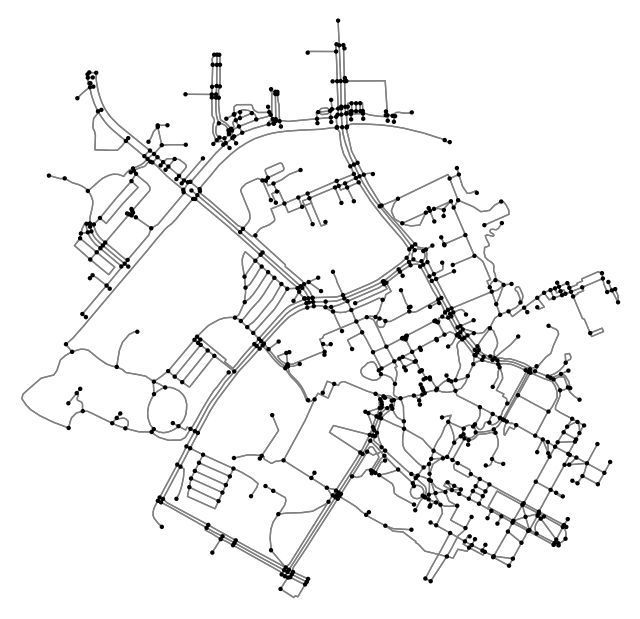

In [35]:
subgraph = nx.ego_graph(graph_proj, orig_node, radius=10, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

## Produce isochrone map

We now have all the components to calculate the nodes that are within certain walking times from Grainger Hall. We will use walking times of 5 to 45 minutes in 5-minute intervals.  

In [36]:
trip_times = [5, 10, 15, 20, 25, 30, 35, 40, 45]  # in minutes

Next, we will define a color for each trip time (or isochrone).

In [37]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0)

This next bit gets a little hairy but basically we will assign each node a color based on the travel time from Grainger Hall. We found this code from [here](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb). We're not sure we could have written this ourselves but it's perfectly OK to appropriate someone else's code if it works.

In [38]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(graph_proj, orig_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in graph_proj.nodes()]
ns = [10 if node in node_colors else 0 for node in graph_proj.nodes()]

Now we can plot our colored nodes onto the original graph.

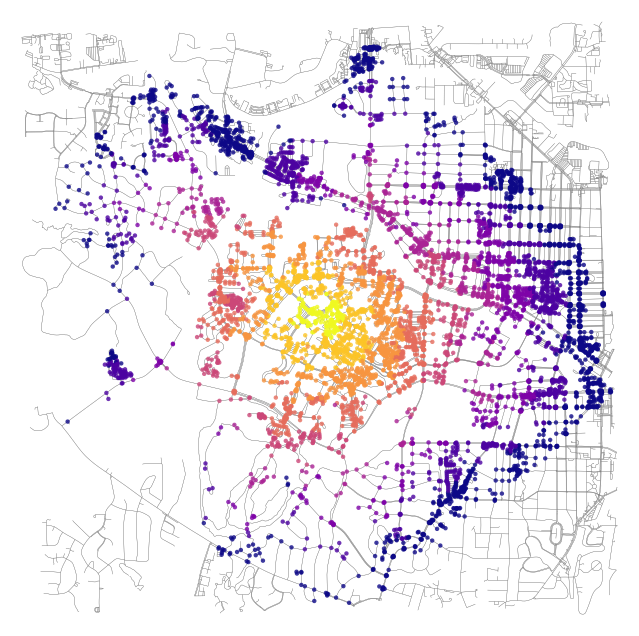

In [39]:
fig, ax = ox.plot_graph(graph_proj, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

This looks great but is of limited use since the buildings that we want to travel to are not necessarily associated with nodes. It would be more convenient to convert this data into polygons which we could use to intersect buildings (or points) of interest.

## Isochrone polygons

Again, we found this code from [here](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb), don't worry if you don't understand it. We first define a function to make the isochrone polygons from positions of the nodes.

In [40]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, orig_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).union_all()
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

Next we will call the function...

In [41]:
isochrone_polys = make_iso_polys(graph_proj, edge_buff=25, node_buff=0, infill=True)
iso_gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

And plot!

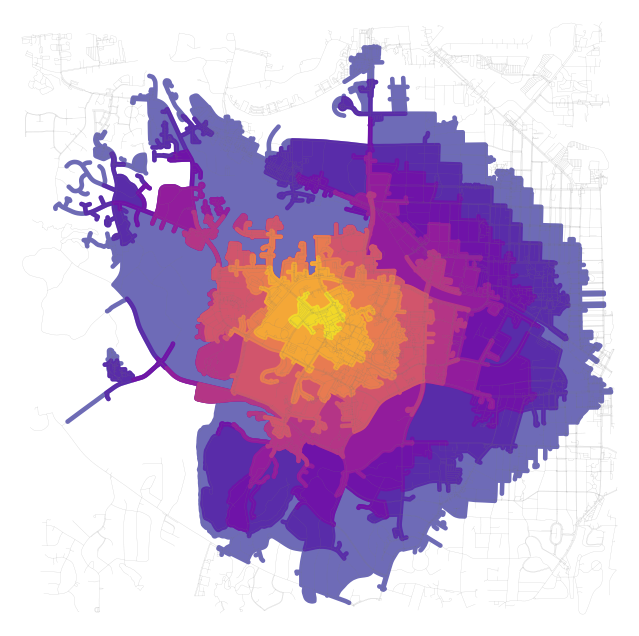

In [42]:
fig, ax = ox.plot_graph(graph_proj, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
iso_gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

Finally, let's intersect these polygons with our cafes to see which are within a given travel time. The `isochrone_polys` are actually in reverse order so the first polygon represents the longest travel time (i.e. 45 minutes) and the last polygon represents the shortest travel time (i.e. 5 minutes) 

`trip_times = [5, 10, 15, 20, 25, 30, 35, 40, 45]`

So to find which cafes are within 35 minutes of walking we would use the **third** item in the index. 

In [43]:
cafes['35-minutes'] = cafes.intersects(isochrone_polys[2])
cafes[['name', 'time_minutes', 'distance_km']][cafes['35-minutes'] == True]

,name,time_minutes,distance_km
0,9th Street Coffee and Juice Bar,33.680957,2.526072
2,Mad Hatter's Bake Shop,34.377492,2.578312
3,Francesca's Dessert Cafe,33.680957,2.526072
4,Panaderia La Loma,30.441644,2.283123
12,Twinnies Cafe,5.744994,0.430875


## Acknowledgments

This demo was inspired by material provided from the [NetworkX](https://networkx.org/documentation/stable/index.html) and [OSMnx](https://osmnx.readthedocs.io/en/stable/) docs as well as the [osmnx-examples](https://github.com/gboeing/osmnx-examples) produced by [Geoff Boeing](https://geoffboeing.com/).